<p align="center">
  <img src="images/logo.png" width="300"/>
</p>

<span style='font-weight:bold; font-size:xx-large'>Valve insight - Switching analysis</span>

Below we show some algorithms from our [ValveInsight](https://www.buerkert.de/de/landingpage/zuverlaessige-analysegeraete-durch-diagnose-mit-valveinsight) portfolio. 

- Switching fault detection 
- Switching duration detection. 

If you have further requests or need a more fine-tuned solution please [contact us](info@burkert.com). 

In [1]:
import pandas as pd

# Data visualization
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# Valve insight algorithms
import algorithms_python.src.valveinsight as vi

# Load data

Load the data from the csv files using pandas.

In [2]:
df_current = pd.read_csv('data/ValveInsight#EvalKit#Current.csv', index_col=False)
df_voltage = pd.read_csv('data/ValveInsight#EvalKit#Voltage.csv', index_col=False)
df_params = pd.read_csv('data/ValveInsight#EvalKit#Attributes.csv', index_col=False)

The current dataframe contains the current measurements. Each row is one measurement. The columns are the timestamps in milliseconds (ms). The sample data was acquired with the Valve Insight eval box.  
The params dataframe contains the information, if a valve switching was successful or not.   
It is based on the criterion that at least 90% of the flow should pass, if the valve opened successfully. 

# Visualize

Visualize the data and show successful and unsuccessful switchings.  

In [3]:
t_ms = df_current.columns.astype(float)

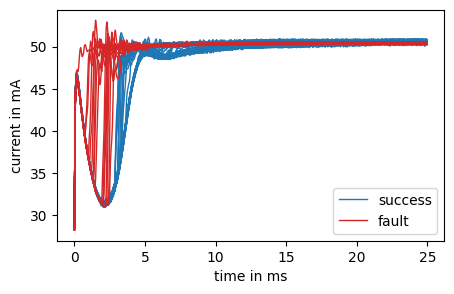

In [4]:
fig, ax = plt.subplots(figsize=(5, 3))

label_success = False
label_fault = False
for i in df_params.index:
    if df_params['fault'].loc[i] == False:
        label = None
        alpha = 0.2
        if not label_success:
            label = 'success'
            label_success = True
        ax.plot(t_ms, df_current.loc[i], 'tab:blue', zorder=-199, label=label, linewidth=1, rasterized=True)
    else:
        label = None
        if not label_fault:
            label = 'fault'
            alpha = 1
            label_fault = True
        ax.plot(t_ms, df_current.loc[i], 'tab:red', alpha=alpha, zorder=-99, label=label, linewidth=1, rasterized=True)

ax.set_xlabel('time in ms')
ax.set_ylabel('current in mA')
_ = ax.legend(loc='best')

# Switching detection

We demonstrate how to detect valve switching using current data. The basic form of the switching detection algorithm is applied, as it offers the highest stability and is suitable for most applications. For more advanced approaches and specialized use cases, refer to the accompanying advanced notebook.

Implementation in an application involves the following steps:
- Measure the inrush current over time.  
- Use the switching detection algorithm to compute an integral value of the inrush current.  
- If the integral exceeds a predefined threshold, the valve switching is deemed successful.  

In [5]:
U = 24  # V

integrals = []
tail_means = []
for i in df_params.index:
    I = df_current.loc[i].to_numpy()
    integral, tail_mean = vi.switching_detection_fixed(t_ms, I*U)
    integrals.append(integral)
    tail_means.append(tail_mean)

df_params['integral - static'] = integrals
df_params['tail mean - static'] = tail_means

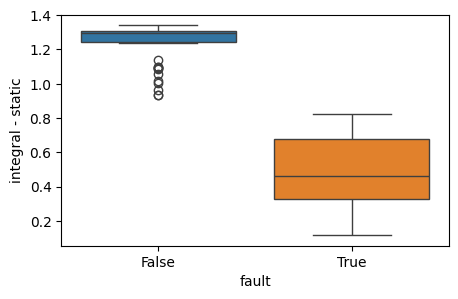

In [6]:
plt.figure(figsize=(5, 3))  
_ = sns.boxplot(x='fault', y='integral - static', hue='fault', data=df_params, legend=False)

The boxplot illustrates the distribution of integral value for the two valve switching states: fault = False (successful switching) and fault = True (switching fault). 

There is a clear separation between the two categories, demonstrating that the integral value effectively distinguishes between successful and faulty valve operations.

While most successful switchings cluster tightly around higher integral values, a few outliers are present. These outliers represent cases where the valve opened only partially. Nevertheless, the valve stroke in these cases was sufficient to allow approximately 90% flow, indicating that the switching was still functionally acceptable despite the lower integral.

# Switching duration

To estimate the valve switching duration, we present two algorithms:

1. Inside Band Method (based on Semi E17-1011 standard):  
This approach defines a successful switching event as one where all current values remain within a specified band around the final steady-state current. It offers high reliability and is aligned with established industry standards.  

2. Integral Threshold Method:
This method uses the same integral calculation as in the switching detection algorithm. It determines the switching duration by identifying the point in time when the integral value first exceeds the predefined threshold for successful switching.  

Both methods are designed for post-acquisition analysis and support a broad range of operating conditions.

|                    | CPU Usage    | Memory usage            | Output quality   | Result Availability   | Parameter scope (*)          |
|--------------------|--------------|-------------------------|------------------|-----------------------|------------------------------|
| Inside band        | Low          | Full current curve      | High             | Post-acquisition      |  Broad range of parameters   |
| Integral threshold | Medium       | Full current curve      | High             | Post-acquisition      |  Broad range of parameters   |

(*) Parameter scope entails various temperatures, pressures, operation times, ...

Implementation in an application involves the following steps:
- Measure the inrush current over time.
- Use the switching duration algorithm to compute the switching duration. 

In [7]:
def plot_duration(s):
    fig, ax = plt.subplots(figsize=(5, 3))
    
    idx = df_params['fault'] == False
    ax.plot(df_params[idx][s], '.', color='tab:blue', label='switching successful')
    idx = df_params['fault'] == True
    ax.plot(df_params[idx][s], '.', color='tab:red', label='switching fault')
    
    ax.set_xlabel('experiment number')
    ax.set_ylabel('switching time - inside band - in ms')
    ax.legend(loc='best')
    
    return fig, ax

## Switching duration - inside band

In [8]:
switching_durations = []
for i in df_params.index:
    I = df_current.loc[i].to_numpy()
    duration = vi.switching_duration_inside_band(t_ms, I, band=0.1)
    switching_durations.append(duration)

df_params['switching duration - inside band - in ms'] = switching_durations

(0.0, 5.0)

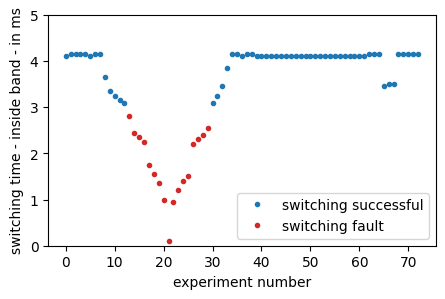

In [9]:
fig, ax = plot_duration('switching duration - inside band - in ms')
ax.set_ylim(0, 5)

## Switching duration - integral threshold

In [10]:
switching_durations = []
for i in df_params.index:
    I = df_current.loc[i].to_numpy()
    duration = vi.switching_duration_integral_threshold(t_ms, I, integral_threshold=0.8)
    switching_durations.append(duration)

df_params['switching duration - integral threshold - in ms'] = switching_durations

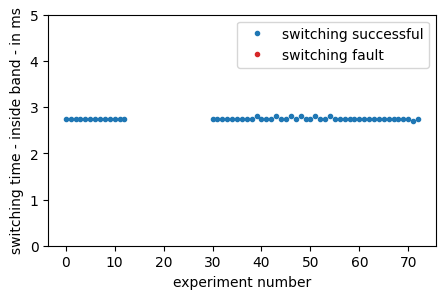

In [11]:
fig, ax = plot_duration('switching duration - integral threshold - in ms')
_ = ax.set_ylim(0, 5)